# Implementation of the ER (Event Rejection) algorithm for four-jet signatures

In [1]:
from turtle import title
from h5py import File
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
#Opening the HDF5 File
input_file = "../user.maboelel.32438279._000005.output.h5"
#input_file = "../forked_TDD/run/EBdata_Output_Dump/output.h5"
data = File(input_file, 'r')
print("List of available datasets: " + str(list(data.keys())))

List of available datasets: ['jets', 'super_tracks', 'super_tracks_associated', 'super_tracks_fixed_cone']


In [4]:
#Accessing the 'Jets' Dataset
jets = data['jets']
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))
print("The shape of the dataset is: " + str(jets.shape))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty'])
The shape of the dataset is: (165789,)


In [5]:
#Getting the events in our sample
uniques = np.unique(jets["eventNumber"])
print("The number of events in our sample is: " + str(len(uniques)))
print("The events_ID array looks like: " + str(uniques))

The number of events in our sample is: 39716
The events_ID array looks like: [3301001 3301002 3301003 ... 4872998 4872999 4873000]


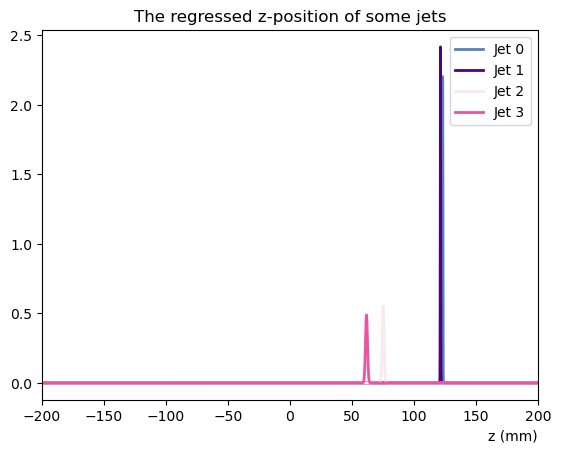

In [6]:
# Visualizing the jets in one event
event_id = uniques[3]
event_jets = jets[jets["eventNumber"] == event_id]
num_jets = len(event_jets)

import matplotlib.pyplot as plt
from scipy.stats import norm
import random
#Generating random colors for  the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(num_jets)]
ic = 0      #color counter
x = np.arange(-4*50, 4*50, 0.1)

for i in range(num_jets):
    #plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"], np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    plt.plot(x, norm.pdf(x, event_jets[i]["dipz_z"]*50, np.exp(-0.5*event_jets[i]["dipz_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    ic = ic + 1    
plt.xlabel("z (mm)", loc='right')
plt.title('The regressed z-position of some jets')
plt.xlim([-4*50, 4*50])
plt.legend()
plt.show()
#plt.cla()

In [7]:
%%time 
#Filtering the four-or-more jet events
fom_events = []

for id in uniques:
    if len(jets[jets["eventNumber"] == id]) >= 4:
        fom_events.append(id)

CPU times: user 17min 51s, sys: 9.34 s, total: 18min 1s
Wall time: 18min 1s


In [8]:
event_jets = jets[jets["eventNumber"] == fom_events[6]]
print(event_jets)

[(75482.71 , nan, 10., -2.277 , 0.0509 , 0.3672 , 0.582 , 0.3655, 6.688, 0, 0, 0, 10, 10, 13, 0.0006266, 3301017, 18.5, 18.5, 6, 17.08, 0.01701)
 (59423.76 , nan,  6.,  1.2705, 0.06073, 0.4246 , 0.5146, 0.3643, 6.66 , 0, 0, 1,  6,  6,  7, 0.0006266, 3301017, 18.5, 18.5, 6, 17.08, 0.01701)
 (32856.91 , nan,  9.,  0.962 , 0.07654, 0.4683 , 0.455 , 0.3538, 6.55 , 0, 0, 2,  9,  9, 11, 0.0006266, 3301017, 18.5, 18.5, 6, 17.08, 0.01701)
 (22955.988, nan,  7.,  1.434 , 0.0989 , 0.3376 , 0.5635, 0.3633, 6.465, 0, 0, 3,  7,  7,  7, 0.0006266, 3301017, 18.5, 18.5, 6, 17.08, 0.01701)
 (20311.902, nan,  1., -1.08  , 0.03214, 0.10547, 0.8623, 0.3335, 1.346, 0, 0, 4,  1,  1,  2, 0.0006266, 3301017, 18.5, 18.5, 6, 17.08, 0.01701)]


In [9]:
import itertools as it

event_jets = jets[jets["eventNumber"] == fom_events[6]]

list = ['a', 'b', 'c', 'd', 'e']

combinations = []

for combination in it.combinations(event_jets, 4):
    combinations.append(combination)
    
for comb in combinations:
    for jet in comb:
        print(jet["dipz_z"])
        break
    break

0.3655


In [10]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event
import itertools as it

def get_max_log_likelihood(event_id):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    z = np.arange(-5*50, 5*50, 0.001)

    combinations = []
    mltl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        log_total_likelihood = num_jets * np.log(np.sqrt(2*np.pi))
            
        for jet in comb:
            mu = jet["dipz_z"] * 50
            sigma = jet["dipz_negLogSigma2"]
            #likelihood = (2*np.pi)**(-1/2) * (sigma)**(-1) * np.exp( -1 * (z - mu)**2 * (2 * sigma^2)**(-1) )
            log_total_likelihood -= ( np.log(sigma) + (z - mu)**2 * (2 * sigma**(2))**(-1) )
    
        mltl_array.append(max(log_total_likelihood))
            
    
    max_log_likelihood = max(mltl_array)
        
    return max_log_likelihood

In [11]:
%%time

print(len(fom_events))
print(len(jets))
get_max_log_likelihood(fom_events[8])

22876
165789
CPU times: user 160 ms, sys: 76 µs, total: 160 ms
Wall time: 211 ms


-3.3417438414497287

In [ ]:
%%time 

max_log_likelihood_list = []
for id in fom_events:
    max_log_likelihood_list.append(get_max_log_likelihood(id))

/tmp/ipykernel_1863562/2977231929.py:23: RuntimeWarning: invalid value encountered in log
  log_total_likelihood -= ( np.log(sigma) + (z - mu)**2 * (2 * sigma**(2))**(-1) )


In [ ]:
def get_max_log_likelihood_dist(name):
    data = File(name, 'r')
    jets = data['jets']
    uniques = np.unique(jets["eventNumber"])
    
    fom_events = []
    for id in uniques:
        if len(jets[jets["eventNumber"] == id]) >= 4:
            fom_events.append(id)
            
    max_log_likelihood_list = []

    for id in fom_events:
        max_log_likelihood_list.append(get_max_log_likelihood(id))
    return max_log_likelihood_list

In [ ]:
max_log_likelihood_list = get_max_log_likelihood_dist("../user.maboelel.32438279._000005.output.h5")

In [ ]:
plt.hist(max_log_likelihood_list)
plt.xlabel("maximum Log L", loc='right')
plt.title('Distribution of the maximum Log of the Likelihood function Per Event')
plt.legend()
plt.show()